This hybrid is done between pureSVD, userKNN and item CF-CBF hybrid

In [10]:
# Import relevant libraries and creates access to library seen in class

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Visualization
from scipy.sparse import * # COO, CSR and CSC matrices


# Access to professor library
from os import sys

package_paths = [
    '../input/mauriziofd/',
]

for pth in package_paths:
    sys.path.append(pth)
    
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

In [17]:
# Read data for the URM and ICM
URM_df= pd.read_csv('../input/recommender-system-2021-challenge-polimi/data_train.csv', dtype={0:int, 1:int, 2:float})
genre_matrix = pd.read_csv('../input/recommender-system-2021-challenge-polimi/data_ICM_genre.csv', dtype={0:int, 1:int, 2:int})
target_users = pd.read_csv('../input/recommender-system-2021-challenge-polimi/data_target_users_test.csv', dtype={0:int})
subgenre_matrix = pd.read_csv('../input/recommender-system-2021-challenge-polimi/data_ICM_subgenre.csv', dtype={0:int, 1:int, 2:int})
channel_matrix = pd.read_csv('../input/recommender-system-2021-challenge-polimi/data_ICM_channel.csv', dtype={0:int, 1:int, 2:int})

target_users.columns = ['user_id']
URM_df.columns = ['user', 'item', 'interaction']
genre_matrix.columns = ['item', 'genre', 'hasgenre']
subgenre_matrix.columns = ['item', 'subgenre', 'hassubgenre']
channel_matrix.columns = ['item', 'channel', 'onchannel']

# Merge datasets into the ICM
genre_subgenre_ICM = pd.merge(genre_matrix, subgenre_matrix, on='item')
ICM_df = pd.merge(genre_subgenre_ICM, channel_matrix, on='item')

ICM_df.pop('hasgenre')
ICM_df.pop('hassubgenre')
ICM_df = ICM_df.rename({'onchannel':'data'}, axis='columns')

# Calculates number of genres, subgenres and channels

# Creates csc matrix from dataframe
URM_all = coo_matrix((URM_df['interaction'].values, (URM_df['user'].values, URM_df['item'].values)))
URM_csr = URM_all.tocsr()
genre_coo = coo_matrix((genre_matrix['hasgenre'].values, (genre_matrix['item'].values, genre_matrix['genre'].values)))
genre_csc = genre_coo.tocsc()
subgenre_coo = coo_matrix((subgenre_matrix['hassubgenre'].values, (subgenre_matrix['item'].values, subgenre_matrix['subgenre'].values)))
subgenre_csc = subgenre_coo.tocsc()
channel_coo = coo_matrix((channel_matrix['onchannel'].values, (channel_matrix['item'].values, channel_matrix['channel'].values)))
channel_csc = channel_coo.tocsc()
channel_csr = channel_coo.tocsr()

ICM_csr = hstack((channel_coo, genre_coo)).tocsr()

# Quite inefficient, maybe there's a unique approach from exercise sessions
n_of_genres = genre_coo.shape[1]

n_of_subgenres = subgenre_coo.shape[1]

n_of_channels = channel_coo.shape[1]

print(n_of_genres, n_of_subgenres, n_of_channels)

8 113 213


In [12]:
# Split in training and validation to assess how good the predictions will be at test time
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_csr, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13649 ( 0.0%) Users that have less than 1 test interactions


Optimize CF CBF hybrid (uses matrix stacking)

In [20]:
import scipy.sparse as sps
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

recommender_ItemKNNCFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_csr)

weights = [1,5,10, 20, 50, 70]
weights_doubled = weights
weights_doubled.append(weights)
similarities = ["cosine", "adjusted"]
MAP_per_k = []

for similarity in similarities:
    for weight in weights:
        recommender_ItemKNNCFCBF.fit(shrink=0.0, topK=200, ICM_weight=weight, similarity=similarity)
    
        result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCFCBF)
    
        MAP_per_k.append(result_df.loc[10]["MAP"])
        print("weight = {}, MAP = {}".format(weight, result_df.loc[10]["MAP"]))
    
    
plt.scatter(weights_doubled[:len(weights)], MAP_per_k[:len(weights)], marker='^') 
plt.scatter(weights_doubled[len(weights):], MAP_per_k[len(weights):], marker='o')
plt.show()

# recommender_ItemKNNCFCBF.fit(ICM_weight = 10.0)

ItemKNN_CFCBF_HybridRecommender: ICM Detected 6 ( 0.0%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 422.71 column/sec. Elapsed time 42.72 sec
EvaluatorHoldout: Processed 13649 (100.0%) in 28.61 sec. Users per second: 477
weight = 1, MAP = 0.20977818887830615
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 178.69 column/sec. Elapsed time 1.68 min
EvaluatorHoldout: Processed 13649 (100.0%) in 27.89 sec. Users per second: 489
weight = 5, MAP = 0.20976890568179316
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 83.88 column/sec. Elapsed time 3.59 min
EvaluatorHoldout: Processed 13649 (100.0%) in 28.02 sec. Users per second: 487
weight = 10, MAP = 0.2097690684938836
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 14200 (78.6%), 47.31 column/sec. Elapsed time 5.00 min
Similarity column 18059

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: dimension mismatch

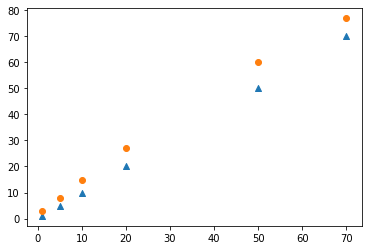

In [9]:
weights = [1,5,10, 20, 50, 70]
weights_doubled = [1,5,10, 20, 50, 70, 1,5,10, 20, 50, 70]
similarities = ["cosine", "adjusted"]
MAP_per_k = [1,5,10, 20, 50, 70, 3,8,15, 27, 60, 77]
plt.scatter(weights_doubled[:len(weights)], MAP_per_k[:len(weights)], marker='^') 
plt.scatter(weights_doubled[len(weights):], MAP_per_k[len(weights):], marker='o')
plt.show()

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session